# INFS7410 Project - Part 2

_version 1.0_

### Preamble

The due date for this assignment is **28 October 2021 16:00 Eastern Australia Standard Time**.

This part of the project is worth 20% of the overall mark for INFS7410 (part 1 + part 2 = 40%). A detailed marking sheet for this assignment is provided alongside this notebook. The project is to be completed individually. 

We recommend that you make an early start on this assignment and proceed by steps. There are several activities you may have already tackled, including setting up the pipeline, manipulating the queries, implement some retrieval functions, and performing evaluation and analysis. Most of the assignment relies on knowledge and code you should have already have experienced in the computer practicals; however, there are some hidden challenges here and there that you may require some time to solve.

### Aim

Project aim: The aim of this project is for you to implement several neural information retrieval methods, evaluate them and compare them in the context of a multi-stage ranking pipeline.

The speficic objectives of Part 2 is to:

* Setup your infrastructure to index the collection and evaluate queries.
* Implement neural information retrieval models (only inference).
* Implement multi-stage ranking pipelines, i.e., BM25 + neural rankers.

### The Information Retrieval Task: Web Passage Ranking

As in part 1 of the project, in part 2 we will consider the problem of open-domain passage ranking in answer to web queries. In this context, users pose queries to the search engine and expect answers in the form of a ranked list of passages (maximum 1000 passages to be retrieved). 

The provided queries are actual queries submitted to the Microsoft Bing search engine. There are approximately 8.8 million passages in the collection, and the goal is to rank them based on their relevance to the queries.


### What we provide you with:

#### Files from practical

* A collection of 8.8 million text passages extracted from web pages (`collection.tsv`— provided in Week 1).
* A query file that contains 43 queries for you to perform retrieval experiments (`queries.tsv`— provided in Week 2).
* A qrel file containing relevance judgements to tune your methods (`qrels.txt`— provided in Week 2).
* Pytorch model files for ANCE.

#### Extra files for this project

* A leaderboard system for you to evaluate how well your system performs.
* A test query file that contains 54 queries for you to generate run files to submit to the leaderboard (`test_queries.tsv`).
* This jupyter notebook, which you will include inside it your implementation and report.
* An hdf5 file that contains TILDEv2 pre-computed terms weights for the collection. Download from this [link](https://drive.google.com/file/d/199IO4E2ThiyLkMWokfr3Y9JY3DWSoFLt/view?usp=sharing)

Put this notebook and provided files under the same directory.

#### What you need to produce

You need to produce:

* Correct implementations of the methods required by this project specifications.
* An explanation of the retrieval methods used, including the formulas that represent the models you implemented and code that implements that formula, an explanation of the evaluation settings followed, and a discussion of the findings. Please refer to the marking sheet to understand how each of these requirements are graded.

You are required to produce both of these within this jupyter notebook.

#### Required methods to implement

In Part 2 of the project, you are required to implement the following retrieval methods. All implementations should be based on your code (except for BM25, where you can use the Pyserini built-in SimpleSearcher).

1. Dense Retriever (ANCE): Use ANCE to re-rank BM25 top-k documents. See the practical in Week 10 for background information.
2. TILDEv2: Use TILDEv2 to re-rank BM25 top-k documents. See the practical in Week 10 for background information.
3. Three-stage ranking pipeline: Use TILDEv2 to re-rank BM25 top-k documents, then use monoBERT to re-rank TILDEv2 top-k documents. See the practical in Week 9 and Week 10 for background information.

You can choose an arbitrary number for the choice of cut-off k, but you need to be aware that these neural models are slow to perform inference on the CPU, where a large k might be infeasible. You are free to use Colab, but make sure you copy your code in this notebook.

For TILDEv2, unlike what you did in practical, we offer you the pre-computed term weights for the whole collection (for more details, see the `Initial packages and functions` cell). This means you can have a fast re-ranking speed for TILDEv2. Use this advantage to trade-off effectiveness and efficiency for your three-stage ranking pipeline implementation.

You should have already attempted many of these implementations above as part of the computer pracs exercises.

#### Required evaluation to perform

In Part 2 of the project, you are required to perform the following evaluation:

1. For all methods, report effectiveness using `queries.tsv` and `qrels.txt` and submit your runs on the `test_queries.tsv` using the parameter values you selected from the `queries.tsv` to the leaderboard system. 
2. Report every method's effectiveness and efficiency (average query latency) on the `queries.tsv` and the corresponding cut-off k into a table. Perform statistical significance analysis across the results of the methods and report them in the tables.
3. Produce a gain-loss plot that compares the most and least effective of the three required methods above in terms of nDCG@10 on `queries.csv`.
4. Comment on trends and differences observed when comparing your findings. Is there a method that consistently outperforms the others on the `queries.tsv` and the `test_queries.tsv`?

Regarding evaluation measures, evaluate the retrieval methods with respect to nDCG at 10 (`ndcg_cut_10`). You should use this measure as the target measure for tuning. Also compute reciprocal rank at 1000 (`recip_rank`),  MAP (`map`) and Recall at 1000 (`recall_1000`).

For all statistical significance analyses, use a paired t-test and distinguish between p<0.05 and p<0.01.

#### How to submit

You will have to submit one file:

1. A zip file containing this notebook (.ipynb) and this notebook **as a PDF document**. The code should be able to be executed by us. Remember to include all your discussion and analysis also in this notebook and not as a separate file.

It needs to be submitted via the relevant Turnitin link in the INFS7410 BlackBoard site by **28 October 2021, 16:00 Eastern Australia Standard Time**, unless you have been given an extension (according to UQ policy), *before* the due date of the assignment.

## Initial packages and functions
----
Unlike prac week 10 which we compute contextualized term weights with TILDEv2 in an "on-the-fly" manner. In this project, we provide an hdf5 file that contains pre-computed term weights for all the passages in the collection. 

Frist, pip install the h5py library:

In [2]:
!pip install h5py

The following cell gives you an example of how to use the file to access token weights and their corresponding token ids given a document id.

In [3]:
import h5py
from transformers import BertTokenizer
f = h5py.File("tildev2_weights.hdf5", 'r')
weights_file = f['documents'][:]  # load the hdf5 file to the memory.

docid = 0
token_weights, token_ids = weights_file[docid]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
for token_id, weight in zip(token_ids.tolist(), token_weights):
    print(f"{tokenizer.decode([token_id])}: {weight}")

ProxyError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/added_tokens.json (Caused by ProxyError('Cannot connect to proxy.', timeout('_ssl.c:1074: The handshake operation timed out')))

Note, these token_ids include stopwords' ids, remember to remove stopwords' ids for query tokens.

----------

In [214]:
# Import all your python libraries and put setup code here.
from pyserini.search import SimpleSearcher
from pyserini.analysis import Analyzer, get_lucene_analyzer
from pyserini.index import IndexReader
from collections import Counter
import json
import numpy as np
from modeling import AnceModel
from transformers import AutoTokenizer
from modeling import TILDEv2
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pytrec_eval
import scipy.stats
import matplotlib.pyplot as plt

device = 'cpu'
ance_model = AnceModel.from_pretrained('ANCE_Model').eval()
ance_model.to(device)
ance_tokenizer = AutoTokenizer.from_pretrained('ANCE_Model')

Open and readin queries file, implement basic search method,
the method uses bm25 as scorer. k is set to 1000, which means
that it will try to find top 1000 documents that might be
relevant with the query.

In [243]:
# Put your implementation of methods here.
# bm25
searcher = SimpleSearcher('indexes/lucene-index-msmarco-passage-noProcessing/')
searcher.set_analyzer(get_lucene_analyzer(stemming=False, stopwords=False))

lucene_analyzer = get_lucene_analyzer(stemming=False, stopwords=False)
analyzer = Analyzer(lucene_analyzer)
searcher = SimpleSearcher('indexes/lucene-index-msmarco-passage-vectors-noProcessing/')
searcher.set_analyzer(lucene_analyzer)

index_reader = IndexReader('indexes/lucene-index-msmarco-passage-vectors-noProcessing/')

# set up queries
queries = []
with open("queries.tsv", "r") as f:
    for line in f.readlines():
        parts = line.split("\t")
        # parts[0] ~> topic id
        # parts[1] ~> query
        queries.append((parts[0], parts[1].strip()))

def search(run_file: str, k: int=10):
    total = []
    with open(run_file, "w") as f:
        for topic_id, query in queries:
            hits = searcher.search(query, k=k)
            q_terms = analyzer.analyze(query)
            # print(q_terms)
            result = []
            for i, hit in enumerate(hits):
                # Compute the statistics.
                tf = index_reader.get_document_vector(hit.docid)
                df= {term: (index_reader.get_term_counts(term, analyzer=None))[0] for term in tf.keys()}
                doc_len = len(tf)
                bm25_score = 0
                c = list((Counter(q_terms) & Counter(tf.keys())).elements())
                
                for term in c:
                    bm25_score += index_reader.compute_bm25_term_weight(hit.docid, term, analyzer=None)
                content = json.loads(hit.raw)
                result.append((hit.docid, bm25_score))
            result.sort(key=lambda x:x[1], reverse = True)
            total.append(result)
                
            for i, r in enumerate(sorted(result, key=lambda x: x[1], reverse=True)):
                # Write the results to our file.
                f.write(f"{topic_id} Q0 {r[0]} {i} {r[1]} infs7410_project2_bm25\n")
    return total

bm25 = search("project2_bm25.run", k=1000)


Implement ANCE model, it uses the result from the basic searcher using bm25.
Obtain the top k tuples of each query, calculate the embeddings of the contents
and the query itself, using dot product to evaluate two embeddings to see if they
are more relevant than others. After the reranking, put the reranking list with
the rest of bm25 search result, write into run file.

In [244]:
# ANCE

def ance_encode(text, device='cpu'):
    # get query inputs
    inputs = ance_tokenizer(
            [text],
            max_length=64,
            padding='longest',
            truncation=True,
            add_special_tokens=True,
            return_tensors='pt'
        )
    # pass query inputs to device and to model
    # use 'cuda:0' if you are using GPU
    inputs.to(device)
    # compute query embeddings
    embeddings = ance_model(inputs["input_ids"]).detach().cpu().numpy().flatten()
    return embeddings

# obtain embeddings of queries
queries_embeddings = []

for topic_id, query in queries:
    inputs = ance_tokenizer(
                [query],
                max_length=64,
                padding='longest',
                truncation=True,
                add_special_tokens=True,
                return_tensors='pt'
            )
    query_embeddings = ance_model(inputs["input_ids"]).detach().cpu().numpy().flatten()
    queries_embeddings.append((topic_id, query_embeddings))
    
def re_rank_ance(run_file: str, j: int=10):
    with open(run_file, "w") as f:
        final = []
        bm25_top_k = search("bm25_top_k.run", k = j)
        index = 0
        for query in bm25_top_k:
            result = []
            for a in range(0, j):
                doc = searcher.doc(query[a][0])
                json_doc = json.loads(doc.raw())
                contents = json_doc["contents"]
                
                passage_embeddings = ance_encode(contents)
                score = np.dot(queries_embeddings[index][1], passage_embeddings)

                result.append((json_doc["id"], score))
            index = index + 1
            result.sort(key=lambda x:x[1], reverse=True)
            final.append(result)

        cur = 0
        for query in queries:
            result = []
            for x in final[cur]:
                result.append(x)
            rest = bm25[cur][j:]
            for x in rest:
                result.append(x)
            cur = cur + 1
            for i, r in enumerate(result):
                f.write(f"{query[0]} Q0 {r[0]} {i} {r[1]} infs7410_project2_bm25_rerank_ance\n")

re_rank_ance("project2_bm25_ance.run", 10)

Implement Tildev2 model, it uses the result from the basic searcher using bm25.
Obtain the top k tuples of each query, calculate the embeddings of the contents
and the query itself, using tildev2_scoring function to evaluate query and passage
to see if they are more relevant than others. After the reranking, put the reranking
list with the rest of bm25 search result, write into run file.

In [245]:
# TILDEv2

model = TILDEv2.from_pretrained("tildev2-noexp").eval()
# tokenizer = AutoTokenizer.from_pretrained("tildev2-noexp")

stop_ids = model.get_stop_ids(tokenizer)

def tildev2_scoreing(query, document):
    # get document term weights
    inputs = tokenizer(document, return_tensors='pt')
    token_ids, token_weights = model.encode(**inputs)
    token_ids = np.array(token_ids)
    token_weights = np.array(token_weights)
    
    # get query token ids
    query_ids = tokenizer(query, add_special_tokens=False)["input_ids"]
    query_ids = [tok_id for tok_id in query_ids if tok_id not in stop_ids]  # remove stopwords for query
    
    # use query token ids to match term weights in the document
    token_idx = [np.where(token_ids == tok_id) for tok_id in query_ids]
    score = 0
    for idx in token_idx:
        if len(idx[0]) != 0:
            score += np.max(token_weights[idx])  # if a query term appears multiple times in the passage, use the max socre
    return score

def tildev2(run_file: str, j: int=10):
    with open(run_file, "w") as f:
        final = []
        bm25_top_k = search("bm25_top_k.run", k = j)
        index = 0
        for query in bm25_top_k:
            result = []
            for a in range(0, j):
                #print(query[a][0])
                doc = searcher.doc(query[a][0])
                json_doc = json.loads(doc.raw())
                contents = json_doc["contents"]
                #print(contents)
                score = tildev2_scoreing(queries[index][1], contents)
                #print(score)
                result.append((json_doc["id"], score))
            index = index + 1
            result.sort(key=lambda x:x[1], reverse=True)
            final.append(result)

#         re_ranked = []
        cur = 0
        for query in queries:
            result = []
            for x in final[cur]:
                result.append(x)
            rest = bm25[cur][j:]
            for x in rest:
                result.append(x)
#             print(result)
#             re_ranked.append(result)
            cur = cur + 1
            for i, r in enumerate(result):
                # Write the results to our file.
                f.write(f"{query[0]} Q0 {r[0]} {i} {r[1]} infs7410_project2_bm25_rerank_tildev2\n")
        return final
                

tildev2_result = tildev2("project2_bm25_tildev2.run", 10)

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

monoBERT = AutoModelForSequenceClassification.from_pretrained('monobert-large-msmarco', cache_dir="./cache")
tokenizer = AutoTokenizer.from_pretrained('monobert-large-msmarco', cache_dir="./cache")

def monoBERT_score(query: str, passage: str):
    ret = tokenizer.encode_plus(query,
                                passage,
                                max_length=512,
                                truncation=True,
                                return_token_type_ids=True,
                                return_tensors='pt')
    input_ids = ret['input_ids'].to(DEVICE)
    tt_ids = ret['token_type_ids'].to(DEVICE)
    with torch.no_grad():
        output, = monoBERT(input_ids, token_type_ids=tt_ids, return_dict=False)
        score = torch.nn.functional.softmax(output, 1)[0, -1].cpu().item()
    return score

def three_stage(run_file: str, j: int=10):
    with open(run_file, "w") as f:
        final = []
        index = 0
        for query in tildev2_result:
            # get the top j tuples of results from tildev2
            result = []
            for a in range(0, j):
                #print(query[a][0])
                doc = searcher.doc(query[a][0])
                json_doc = json.loads(doc.raw())
                contents = json_doc["contents"]
                #print(contents)
                score = monoBERT_score(queries[index][1], contents)
                #print(score)
                result.append((json_doc["id"], score))
            index = index + 1
            result.sort(key=lambda x:x[1], reverse=True)
            final.append(result)

        length = len(tildev2_result[0])
        cur = 0
        # append all seperated re-ranked results together
        # and write them into run file
        for query in queries:
            result = []
            for x in final[cur]:
                result.append(x)
#             rest = tildev2_result[cur][j:length]
            for x in tildev2_result[cur][j:length]:
                result.append(x)
            for x in bm25[cur][length:]:
                result.append(x)
#             print(result)
            cur = cur + 1
            for i, r in enumerate(result):
                f.write(f"{query[0]} Q0 {r[0]} {i} {r[1]} infs7410_project2_three_stages\n")
        return final

three_stage = three_stage("project2_three_stages.run", 5)

NameError: name 'tildev2_result' is not defined

In [247]:
# evaluations
def print_results(run_file, qrel_file='qrel.txt', measures=["map", "recip_rank", "ndcg_cut_10", "recall_1000"]):        
    with open(run_file, "r") as f:
        run = pytrec_eval.parse_run(f)  
    with open(qrel_file, "r") as f:
        msmarco_qrels = pytrec_eval.parse_qrel(f)
    evaluator = pytrec_eval.RelevanceEvaluator(query_relevance=msmarco_qrels, measures=measures)
    results = evaluator.evaluate(run)
    for measure in measures:
        print('{:25s}{:8s}{:.4f}'.format(measure, 'all', pytrec_eval.compute_aggregated_measure(measure,
                                  [query_measures[measure]for query_measures in results.values()]))) 



print_results("project2_bm25.run")
print()
print_results("project2_bm25_ance.run")
print()
print_results("project2_bm25_tildev2.run")
print()
print_results("project2_three_stages.run")



map                      all     0.3566
recip_rank               all     0.8113
ndcg_cut_10              all     0.4853
recall_1000              all     0.6881

map                      all     0.3671
recip_rank               all     0.8549
ndcg_cut_10              all     0.5291
recall_1000              all     0.6881

map                      all     0.3665
recip_rank               all     0.8725
ndcg_cut_10              all     0.5318
recall_1000              all     0.6881

map                      all     0.2322
recip_rank               all     0.6216
ndcg_cut_10              all     0.3344
recall_1000              all     0.6881


|   run(k=10)  	|   map  	| racip_rank 	| ndcg_10 	| recall_1000 	|
|:------------:	|:------:	|:----------:	|:-------:	|:-----------:	|
|     bm25     	| 0.3566 	|   0.8113   	|  0.4853 	|    0.6881   	|
|     ance     	| 0.3671 	|   0.8549   	|  0.5291 	|    0.6881   	|
|    tildev2   	| 0.3665 	|   0.8725   	|  0.5318 	|    0.6881   	|
| three_stages 	| 0.2322 	|   0.6216   	|  0.3344 	|    0.6881   	|


In [248]:
with open("project2_bm25.run", "r") as f:
    project2_bm25_run = pytrec_eval.parse_run(f)
with open("project2_bm25_ance.run", "r") as f:
    project2_ance_run = pytrec_eval.parse_run(f)
with open("project2_bm25_tildev2.run", "r") as f:
    project2_tildev2_run = pytrec_eval.parse_run(f)
with open("project2_three_stages.run", "r") as f:
    project2_three_stages_run = pytrec_eval.parse_run(f)  
    
bm25_results = evaluator.evaluate(project2_bm25_run)
ance_results = evaluator.evaluate(project2_ance_run)
tildev2_results = evaluator.evaluate(project2_tildev2_run)
three_stages_results = evaluator.evaluate(project2_three_stages_run)

query_ids = list(
    set(bm25_results.keys()) & set(acne_results.keys()))

bm25_scores = [
    bm25_results[query_id]["ndcg_cut_10"] for query_id in query_ids]
acne_scores = [
    acne_results[query_id]["ndcg_cut_10"] for query_id in query_ids]    
tildev2_scores = [
    tildev2_results[query_id]["ndcg_cut_10"] for query_id in query_ids]
three_stages_scores = [
    three_stages_results[query_id]["ndcg_cut_10"] for query_id in query_ids]

print(scipy.stats.ttest_rel(bm25_scores, acne_scores))
print(scipy.stats.ttest_rel(bm25_scores, tildev2_scores))
print(scipy.stats.ttest_rel(bm25_scores, three_stages_scores))



Ttest_relResult(statistic=-3.9394580374294095, pvalue=0.000302508885891443)
Ttest_relResult(statistic=-3.9884972830002465, pvalue=0.0002605599672805988)
Ttest_relResult(statistic=3.98408896193045, pvalue=0.0002640871575169761)


From the result of statistical significance, it can be seen that comparing to
fundamental bm25, both ANCE and tildev2 provide rather significantly effective
models.

Furthermore, tildev2 model and ACNE model have rather similar results in terms
of the mearsures like map, recip_rank ndcg_cut_10 and recall_1000. Tildev2 might
have a slightly better performance than ANCE does. Both two models performs better
than the three-stages model which combines them together. Result of three-stages
model was not ideal, though having high statistical significance, but performance
was much lower. I'm not sure if it was because my implementation gets wrong in
some place.

Overally, map, recip_rank and ndcg_cut_10 all have been improved after applying
ACNE model and tildev2 model individually, improvement of recall_1000 was not
quite obvious, it might due to the number of total documents retrieved is kept
as 1000. Also, the fundamental searcher using bm25 can be a potential factor. Both
cause the total number of top 1000 retrieved relevant documents stays the same.

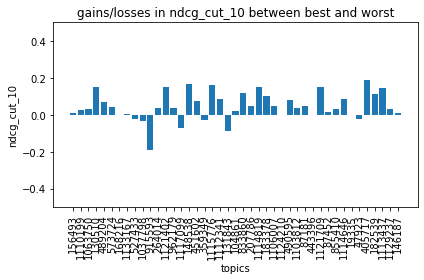

In [249]:
measure = "ndcg_cut_10"
title = "gains/losses in ndcg_cut_10 between best and worst"

r = dict([(key, value[measure]) for key, value in bm25_results.items()])
r1 = dict([(key, value[measure]) for key, value in bm25_results.items()])
r2 = dict([(key, value[measure]) for key, value in tildev2_results.items()])
ind = np.arange(len(r1))
# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
plt.bar(ind, np.subtract(list(r2.values()), list(r1.values())))
plt.xticks(ind, list(r.keys()), rotation="vertical")
plt.ylim(-0.5, 0.5)
plt.title(title)
plt.ylabel(measure)
plt.xlabel("topics")
plt.tight_layout()
plt.show()

Note: the y axis has been extended(zoomed in), original is (-1, 1), to make the graph more clear, it
has been set to (-0.5, 0.5)

When you have described and provided implementations for each method, include a table with statistical analysis here. 

For convenience, you can use tools like this one to make it easier: https://www.tablesgenerator.com/markdown_tables, or if you are using pandas, you can convert dataframes to markdown https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_markdown.html